In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Load data

In [2]:
DATA_DIR = '../data/raw'
dataset_names = {'pCO2': 'pCO2_2D_mon_CESM001_1x1_198201-201701.nc',
                 'XCO2': 'XCO2_1D_mon_CESM001_native_198201-201701.nc',
                 'SST': 'SST_2D_mon_CESM001_1x1_198201-201701.nc',
                 'SSS': 'SSS_2D_mon_CESM001_1x1_198201-201701.nc',
                 'MLD': 'MLD_2D_mon_CESM001_1x1_198201-201701.nc',
                 'Chl': 'Chl_2D_mon_CESM001_1x1_198201-201701.nc'}
ds = {}
for dataset in dataset_names.keys():
    filename = os.path.join(DATA_DIR, dataset_names[dataset])
    ds[dataset] = xr.open_dataset(filename)

# Convert to dataframe

In [3]:
df = {}
df_socat = {}
for dataset in ds.keys():
    df[dataset] = ds[dataset][dataset].to_dataframe().reset_index()
    
    # XCO2 is only time dependent, so it has no XCO2_socat feature
    if dataset == 'XCO2':
        continue
        
    df_socat[dataset] = ds[dataset]['{}_socat'.format(dataset)].to_dataframe().reset_index()

In [4]:
df['pCO2'].head()

,time,ylat,xlon,pCO2
0,1982-01-16 12:00:00,-89.5,0.5,NaN
1,1982-01-16 12:00:00,-89.5,1.5,NaN
2,1982-01-16 12:00:00,-89.5,2.5,NaN
3,1982-01-16 12:00:00,-89.5,3.5,NaN
4,1982-01-16 12:00:00,-89.5,4.5,NaN


In [5]:
df['pCO2'].tail()

,time,ylat,xlon,pCO2
27280795,2017-01-16 12:00:00,89.5,355.5,373.818737
27280796,2017-01-16 12:00:00,89.5,356.5,373.846099
27280797,2017-01-16 12:00:00,89.5,357.5,373.873182
27280798,2017-01-16 12:00:00,89.5,358.5,373.900054
27280799,2017-01-16 12:00:00,89.5,359.5,373.926773


# Will any feature have 0 value?

In [6]:
for feature in df.keys():
    if (df[feature][feature] == 0).sum() > 0:
        print("There are {} values for the feature {}".format((df[feature][feature] == 0).sum(), feature))

So, for all the features, each grid has either NaN or non-zero value.

# For how much percent of area on Earth can each feature be inspected?

In [7]:
for feature in df.keys():
    pct = df[feature][feature].notnull().sum() / df[feature].shape[0]
    print("{}: {}".format(feature, pct))

pCO2: 0.6337962962962963
XCO2: 1.0
SST: 0.6337962962962963
SSS: 0.6337962962962963
MLD: 0.6337962962962963
Chl: 0.6337962962962963


# What is the ratio of socat area?

In [8]:
for feature in df.keys():
    if feature == 'XCO2': continue
    ratio = ((df_socat[feature]['{}_socat'.format(feature)].notnull()) \
             & (df_socat[feature]['{}_socat'.format(feature)] != 0)).sum() \
        / df[feature][feature].notnull().sum()
    print("{}: {}".format(feature, ratio))

pCO2: 0.014203026291361658
SST: 0.014203026291361658
SSS: 0.014203026291361658
MLD: 0.014203026291361658
Chl: 0.014203026291361658


# Histograms of each feature for both all-location and socat-location

* All-location

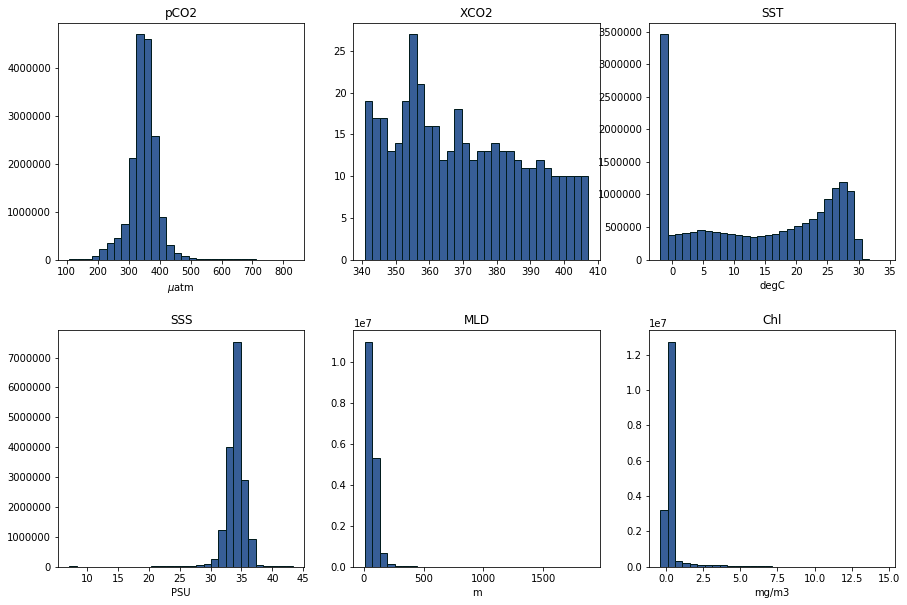

In [83]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
feature_unit = {'pCO2': '$\mu$atm',
                'XCO2': '',
                'SST': 'degC',
                'SSS': 'PSU',
                'MLD': 'm',
                'Chl': 'mg/m3'}

i = 0
j = 0
for feature in df.keys():
    values = df[feature][df[feature][feature].notnull()][feature]
    axs[i, j].hist(values, 30, facecolor='#375E97', edgecolor='#021C1E')
    axs[i, j].set_title(feature)
    axs[i, j].set_xlabel(feature_unit[feature])
    if j < 2:
        j += 1
    else:
        i += 1
        j = 0
plt.subplots_adjust(hspace=.3)
plt.show()

* SOCAT-location

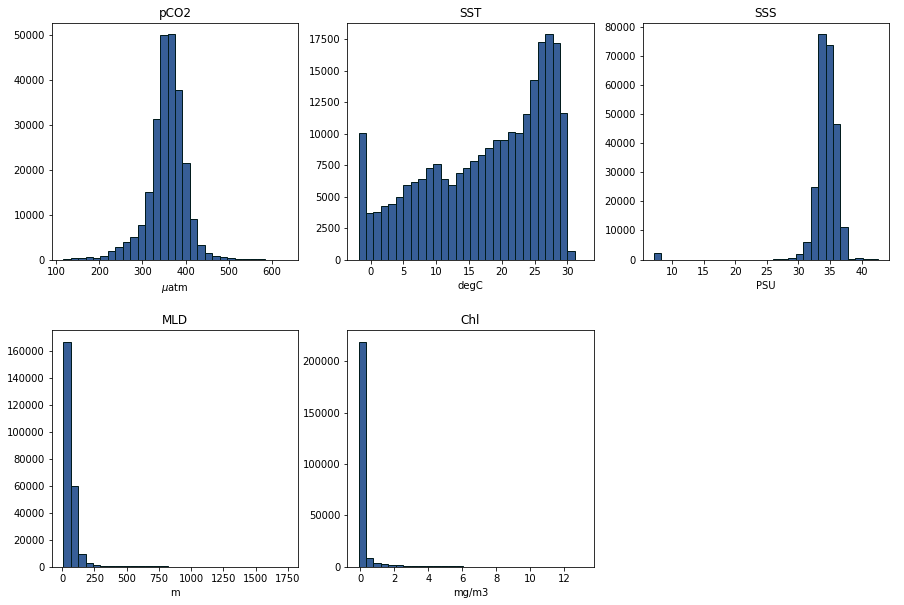

In [88]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
feature_unit = {'pCO2': '$\mu$atm',
                'XCO2': '',
                'SST': 'degC',
                'SSS': 'PSU',
                'MLD': 'm',
                'Chl': 'mg/m3'}

i = 0
j = 0
for feature in df_socat.keys():
    feature_socat = '{}_socat'.format(feature)
    values = df_socat[feature][(df_socat[feature][feature_socat].notnull()) \
                         & (df_socat[feature][feature_socat] != 0)][feature_socat]
    axs[i, j].hist(values, 30, facecolor='#375E97', edgecolor='#021C1E')
    axs[i, j].set_title(feature)
    axs[i, j].set_xlabel(feature_unit[feature])
    if j < 2:
        j += 1
    else:
        i += 1
        j = 0
axs[-1, -1].axis('off')
plt.subplots_adjust(hspace=.3)
plt.show()